In [26]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import nltk
import string

from sklearn.model_selection import learning_curve


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

## Read and Prep Data


In [27]:
tqdm.pandas()

In [28]:
# from google.colab import drive
# drive.mount('/content/gdrive') 
# path = '/content/gdrive/MyDrive/IFT 6390/kaggle2/'

In [29]:
# input_path = path+'data/input/'
input_path = 'data/input/'

In [30]:
all_train_data = pd.read_csv(input_path + 'train_data_prepped.csv').fillna('')
all_test_data = pd.read_csv(input_path + 'test_data_prepped.csv').fillna('')

In [31]:
all_train_data.head(1)

,id,text,cat,text_no_punc,text_no_numerals,text_no_sw,text_porter_stemmed,text_lancaster_stemmed,text_lemmatized
0,0,anyway im getting of for a while,train,anyway im getting of for a while,anyway im getting of for a while,anyway im getting,anyway im get of for a while,anyway im get of for a whil,anyway im getting of for a while


In [32]:
all_test_data.head(1)

,id,text,cat,text_no_punc,text_no_numerals,text_no_sw,text_porter_stemmed,text_lancaster_stemmed,text_lemmatized
0,0,so cut... missed out on all the tce extreme me...,test,so cut missed out on all the tce extreme merch...,so cut missed out on all the tce extreme merch...,cut missed tce extreme merch! sizes,so cut miss out on all the tce extrem merch! i...,so cut miss out on al the tce extrem merch! in...,so cut missed out on all the tce extreme merch...


In [33]:
all_train_data[all_train_data.isnull().any(axis=1)]

,id,text,cat,text_no_punc,text_no_numerals,text_no_sw,text_porter_stemmed,text_lancaster_stemmed,text_lemmatized


In [34]:
all_test_data[all_test_data.isnull().any(axis=1)]

,id,text,cat,text_no_punc,text_no_numerals,text_no_sw,text_porter_stemmed,text_lancaster_stemmed,text_lemmatized


load train targets, binarize, drop nuetrals

In [35]:
train_target = pd.read_csv(input_path + 'train_results.csv')
train_target['target'].value_counts()

positive    520436
negative    519803
neutral         84
Name: target, dtype: int64

In [36]:
train_target.head()

,id,target
0,0,positive
1,1,negative
2,2,positive
3,3,positive
4,4,negative


In [37]:
train_target['target'] = [0 if t == 'negative' else 2 if t == 'positive' else 2 for t in train_target['target'].values]

In [38]:
all_train_data['target'] = train_target['target']

### prepare bag of words<br>
we need a different model for each text format

Naive Bayes doesn't have any hyperparameters, so we'll test different versions of the text processing with different versions of naive bayes and corpos generation

the following parameters will be tested<br>
1. size of corpus vocab
2. corpus ngram varieties
3. bernoulli, multinomial or gaussian naive bayes
4. stemming/lemmatizing methods

In [40]:
vocab_sizes = [128, 1024, 8196, 16384]
ngrams = [(1, 1), (2, 2), (1, 2), (1, 3), (1, 4)]
models = [BernoulliNB(), GaussianNB(), MultinomialNB()]
text_columns = ['text_no_numerals', 'text_no_sw', 'text_porter_stemmed', 'text_lancaster_stemmed', 'text_lemmatized']
threshold = 0.5

# shuffle train data
all_train_data = all_train_data.sample(len(all_train_data))

# get data and target
train_X = all_train_data.iloc[:, :-1]
train_y  = all_train_data.iloc[:, -1]


# get 10000 data points for first round of training
train_v1 = train_X[:10_000]
targets_v1 = train_y[:10_000]

In [41]:
targets_v1.head()

745209    2
252829    2
590208    2
401783    0
801624    0
Name: target, dtype: int64

In [42]:
def trainModels(df, targets, vocab_sizes, models, text_columns, ngrams, threshold):

    param_tracker = []
    counter = 1
    for size in tqdm(vocab_sizes):

        for model in models:

            for col in text_columns:


                for ng in tqdm(ngrams):

                    counter+=1
                    if counter % 10==0:
                        print(f'{counter}')
                    vectorizer = CountVectorizer(max_features=size, ngram_range=ng)

                    BOW = vectorizer.fit_transform(df[col])
                    BOW_array = BOW.toarray()

                    X_train, X_valid, y_train, y_valid = train_test_split(BOW_array, targets, test_size=0.2, random_state=42)


                    model.fit(X_train, y_train)


                    prob_predictions = model.predict_proba(X_valid)

                    # gets index of 1 column in prob_predictions
                    pos_predictions = [pred[list(model.classes_).index(2)] for pred in prob_predictions]

                    num_correct_pred = 0
                    for pred, actual in zip(pos_predictions, y_valid):
                        if pred >= threshold:
                            binary_pred = 2
                        else:
                            binary_pred = 0

                        if binary_pred==actual:
                            num_correct_pred+=1
                    accuracy = num_correct_pred / len(y_valid)
                    print(f'accuracy: {accuracy}')
                    print('\n\n')

                    param_tracker.append((size, str(model), col, ng, accuracy))
                    
    param_df = pd.DataFrame(param_tracker, columns = ['vocab_size', 'model_type', 'text_column', 'ngram', 'accuracy_round1'])
    param_df = param_df.sort_values(by='accuracy_round1', ascending=False)
    return param_df

                    
                
    # for vocab size we'll test

In [43]:
param_df = trainModels(train_v1, targets_v1, vocab_sizes, models, text_columns, ngrams, threshold)

 20%|██████████████                                                        | 1/5 [00:00<00:00,  5.10it/s]

accuracy: 0.671






 40%|████████████████████████████                                          | 2/5 [00:00<00:00,  3.84it/s]

accuracy: 0.567






 60%|██████████████████████████████████████████                            | 3/5 [00:00<00:00,  3.16it/s]

accuracy: 0.661






 80%|████████████████████████████████████████████████████████              | 4/5 [00:01<00:00,  2.16it/s]

accuracy: 0.661






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


accuracy: 0.661






 20%|██████████████                                                        | 1/5 [00:00<00:00,  7.50it/s]

accuracy: 0.6475






 40%|████████████████████████████                                          | 2/5 [00:00<00:00,  5.46it/s]

accuracy: 0.535






 60%|██████████████████████████████████████████                            | 3/5 [00:00<00:00,  4.38it/s]

accuracy: 0.646



10



 80%|████████████████████████████████████████████████████████              | 4/5 [00:01<00:00,  3.24it/s]

accuracy: 0.646






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.07it/s]


accuracy: 0.646






 20%|██████████████                                                        | 1/5 [00:00<00:00,  6.44it/s]

accuracy: 0.678






 40%|████████████████████████████                                          | 2/5 [00:00<00:00,  4.23it/s]

accuracy: 0.57






 60%|██████████████████████████████████████████                            | 3/5 [00:00<00:00,  3.46it/s]

accuracy: 0.675






 80%|████████████████████████████████████████████████████████              | 4/5 [00:01<00:00,  2.31it/s]

accuracy: 0.675






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.16it/s]


accuracy: 0.675






 20%|██████████████                                                        | 1/5 [00:00<00:00,  5.45it/s]

accuracy: 0.6755






 40%|████████████████████████████                                          | 2/5 [00:00<00:00,  4.07it/s]

accuracy: 0.568






 60%|██████████████████████████████████████████                            | 3/5 [00:00<00:00,  3.37it/s]

accuracy: 0.6685



20



 80%|████████████████████████████████████████████████████████              | 4/5 [00:01<00:00,  2.17it/s]

accuracy: 0.6685






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


accuracy: 0.6685






 20%|██████████████                                                        | 1/5 [00:00<00:00,  5.98it/s]

accuracy: 0.672






 40%|████████████████████████████                                          | 2/5 [00:00<00:00,  4.19it/s]

accuracy: 0.565






 60%|██████████████████████████████████████████                            | 3/5 [00:00<00:00,  3.36it/s]

accuracy: 0.662






 80%|████████████████████████████████████████████████████████              | 4/5 [00:01<00:00,  2.27it/s]

accuracy: 0.662






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.01it/s]


accuracy: 0.662






 20%|██████████████                                                        | 1/5 [00:00<00:00,  5.36it/s]

accuracy: 0.649






 40%|████████████████████████████                                          | 2/5 [00:00<00:00,  3.73it/s]

accuracy: 0.566






 60%|██████████████████████████████████████████                            | 3/5 [00:00<00:00,  3.01it/s]

accuracy: 0.6465



30



 80%|████████████████████████████████████████████████████████              | 4/5 [00:01<00:00,  2.10it/s]

accuracy: 0.6465






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


accuracy: 0.6465






 20%|██████████████                                                        | 1/5 [00:00<00:00,  6.80it/s]

accuracy: 0.6425






 40%|████████████████████████████                                          | 2/5 [00:00<00:00,  5.12it/s]

accuracy: 0.5315






 60%|██████████████████████████████████████████                            | 3/5 [00:00<00:00,  4.16it/s]

accuracy: 0.642






 80%|████████████████████████████████████████████████████████              | 4/5 [00:01<00:00,  3.07it/s]

accuracy: 0.642






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.93it/s]


accuracy: 0.642






 20%|██████████████                                                        | 1/5 [00:00<00:00,  6.08it/s]

accuracy: 0.649






 40%|████████████████████████████                                          | 2/5 [00:00<00:00,  4.12it/s]

accuracy: 0.568






 60%|██████████████████████████████████████████                            | 3/5 [00:00<00:00,  3.34it/s]

accuracy: 0.647



40



 80%|████████████████████████████████████████████████████████              | 4/5 [00:01<00:00,  2.25it/s]

accuracy: 0.647






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


accuracy: 0.647






 20%|██████████████                                                        | 1/5 [00:00<00:00,  5.81it/s]

accuracy: 0.644






 40%|████████████████████████████                                          | 2/5 [00:00<00:00,  4.13it/s]

accuracy: 0.564






 60%|██████████████████████████████████████████                            | 3/5 [00:00<00:00,  3.36it/s]

accuracy: 0.6455






 80%|████████████████████████████████████████████████████████              | 4/5 [00:01<00:00,  2.16it/s]

accuracy: 0.6455






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


accuracy: 0.6455






 20%|██████████████                                                        | 1/5 [00:00<00:00,  5.84it/s]

accuracy: 0.643






 40%|████████████████████████████                                          | 2/5 [00:00<00:00,  4.01it/s]

accuracy: 0.565






 60%|██████████████████████████████████████████                            | 3/5 [00:00<00:00,  3.21it/s]

accuracy: 0.642



50



 80%|████████████████████████████████████████████████████████              | 4/5 [00:01<00:00,  2.15it/s]

accuracy: 0.642






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


accuracy: 0.642






 20%|██████████████                                                        | 1/5 [00:00<00:00,  5.87it/s]

accuracy: 0.6695






 40%|████████████████████████████                                          | 2/5 [00:00<00:00,  4.21it/s]

accuracy: 0.5745






 60%|██████████████████████████████████████████                            | 3/5 [00:00<00:00,  3.40it/s]

accuracy: 0.6705






 80%|████████████████████████████████████████████████████████              | 4/5 [00:01<00:00,  2.26it/s]

accuracy: 0.6705






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.02it/s]


accuracy: 0.6705






 20%|██████████████                                                        | 1/5 [00:00<00:00,  7.56it/s]

accuracy: 0.6415






 40%|████████████████████████████                                          | 2/5 [00:00<00:00,  5.63it/s]

accuracy: 0.5355






 60%|██████████████████████████████████████████                            | 3/5 [00:00<00:00,  4.47it/s]

accuracy: 0.641



60



 80%|████████████████████████████████████████████████████████              | 4/5 [00:01<00:00,  3.44it/s]

accuracy: 0.641






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.35it/s]


accuracy: 0.641






 20%|██████████████                                                        | 1/5 [00:00<00:00,  6.60it/s]

accuracy: 0.6805






 40%|████████████████████████████                                          | 2/5 [00:00<00:00,  4.50it/s]

accuracy: 0.5735






 60%|██████████████████████████████████████████                            | 3/5 [00:00<00:00,  3.57it/s]

accuracy: 0.681






 80%|████████████████████████████████████████████████████████              | 4/5 [00:01<00:00,  2.37it/s]

accuracy: 0.681






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


accuracy: 0.681






 20%|██████████████                                                        | 1/5 [00:00<00:00,  6.63it/s]

accuracy: 0.675






 40%|████████████████████████████                                          | 2/5 [00:00<00:00,  4.43it/s]

accuracy: 0.573






 60%|██████████████████████████████████████████                            | 3/5 [00:00<00:00,  3.56it/s]

accuracy: 0.6745



70



 80%|████████████████████████████████████████████████████████              | 4/5 [00:01<00:00,  2.38it/s]

accuracy: 0.6745






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.09it/s]


accuracy: 0.6745






 20%|██████████████                                                        | 1/5 [00:00<00:00,  6.38it/s]

accuracy: 0.6695






 40%|████████████████████████████                                          | 2/5 [00:00<00:00,  4.36it/s]

accuracy: 0.5695






 60%|██████████████████████████████████████████                            | 3/5 [00:00<00:00,  3.52it/s]

accuracy: 0.6695






 80%|████████████████████████████████████████████████████████              | 4/5 [00:01<00:00,  2.32it/s]

accuracy: 0.6695






 25%|█████████████████▌                                                    | 1/4 [00:34<01:44, 34.75s/it]

accuracy: 0.6695






 20%|██████████████                                                        | 1/5 [00:00<00:02,  1.87it/s]

accuracy: 0.7355






 40%|████████████████████████████                                          | 2/5 [00:01<00:01,  1.68it/s]

accuracy: 0.6255






 60%|██████████████████████████████████████████                            | 3/5 [00:01<00:01,  1.53it/s]

accuracy: 0.7295



80



 80%|████████████████████████████████████████████████████████              | 4/5 [00:02<00:00,  1.25it/s]

accuracy: 0.729






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.17it/s]


accuracy: 0.7335






 20%|██████████████                                                        | 1/5 [00:00<00:01,  2.04it/s]

accuracy: 0.717






 40%|████████████████████████████                                          | 2/5 [00:01<00:01,  1.88it/s]

accuracy: 0.575






 60%|██████████████████████████████████████████                            | 3/5 [00:01<00:01,  1.72it/s]

accuracy: 0.7205






 80%|████████████████████████████████████████████████████████              | 4/5 [00:02<00:00,  1.52it/s]

accuracy: 0.721






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.48it/s]


accuracy: 0.7235






 20%|██████████████                                                        | 1/5 [00:00<00:02,  1.98it/s]

accuracy: 0.7365






 40%|████████████████████████████                                          | 2/5 [00:01<00:01,  1.72it/s]

accuracy: 0.635






 60%|██████████████████████████████████████████                            | 3/5 [00:01<00:01,  1.56it/s]

accuracy: 0.7365



90



 80%|████████████████████████████████████████████████████████              | 4/5 [00:02<00:00,  1.27it/s]

accuracy: 0.734






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.20it/s]


accuracy: 0.733






 20%|██████████████                                                        | 1/5 [00:00<00:02,  1.93it/s]

accuracy: 0.729






 40%|████████████████████████████                                          | 2/5 [00:01<00:01,  1.70it/s]

accuracy: 0.6345






 60%|██████████████████████████████████████████                            | 3/5 [00:01<00:01,  1.55it/s]

accuracy: 0.7265






 80%|████████████████████████████████████████████████████████              | 4/5 [00:02<00:00,  1.28it/s]

accuracy: 0.7235






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.20it/s]


accuracy: 0.728






 20%|██████████████                                                        | 1/5 [00:00<00:01,  2.05it/s]

accuracy: 0.7355






 40%|████████████████████████████                                          | 2/5 [00:01<00:01,  1.72it/s]

accuracy: 0.6245






 60%|██████████████████████████████████████████                            | 3/5 [00:01<00:01,  1.50it/s]

accuracy: 0.7315



100



 80%|████████████████████████████████████████████████████████              | 4/5 [00:02<00:00,  1.28it/s]

accuracy: 0.7285






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.26it/s]


accuracy: 0.728






 20%|██████████████                                                        | 1/5 [00:00<00:01,  2.90it/s]

accuracy: 0.6525






 40%|████████████████████████████                                          | 2/5 [00:00<00:01,  2.43it/s]

accuracy: 0.605






 60%|██████████████████████████████████████████                            | 3/5 [00:01<00:00,  2.14it/s]

accuracy: 0.691






 80%|████████████████████████████████████████████████████████              | 4/5 [00:02<00:00,  1.69it/s]

accuracy: 0.6875






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.58it/s]


accuracy: 0.6915






 20%|██████████████                                                        | 1/5 [00:00<00:01,  3.05it/s]

accuracy: 0.642






 40%|████████████████████████████                                          | 2/5 [00:00<00:01,  2.73it/s]

accuracy: 0.559






 60%|██████████████████████████████████████████                            | 3/5 [00:01<00:00,  2.52it/s]

accuracy: 0.654



110



 80%|████████████████████████████████████████████████████████              | 4/5 [00:01<00:00,  2.15it/s]

accuracy: 0.659






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.06it/s]


accuracy: 0.6585






 20%|██████████████                                                        | 1/5 [00:00<00:01,  3.00it/s]

accuracy: 0.65






 40%|████████████████████████████                                          | 2/5 [00:00<00:01,  2.49it/s]

accuracy: 0.614






 60%|██████████████████████████████████████████                            | 3/5 [00:01<00:00,  2.05it/s]

accuracy: 0.691






 80%|████████████████████████████████████████████████████████              | 4/5 [00:02<00:00,  1.56it/s]

accuracy: 0.6905






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.44it/s]


accuracy: 0.696






 20%|██████████████                                                        | 1/5 [00:00<00:01,  2.62it/s]

accuracy: 0.658






 40%|████████████████████████████                                          | 2/5 [00:00<00:01,  2.15it/s]

accuracy: 0.612






 60%|██████████████████████████████████████████                            | 3/5 [00:01<00:01,  1.92it/s]

accuracy: 0.679



120



 80%|████████████████████████████████████████████████████████              | 4/5 [00:02<00:00,  1.50it/s]

accuracy: 0.677






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.39it/s]


accuracy: 0.68






 20%|██████████████                                                        | 1/5 [00:00<00:01,  2.58it/s]

accuracy: 0.6535






 40%|████████████████████████████                                          | 2/5 [00:00<00:01,  2.13it/s]

accuracy: 0.6065






 60%|██████████████████████████████████████████                            | 3/5 [00:01<00:01,  1.91it/s]

accuracy: 0.702






 80%|████████████████████████████████████████████████████████              | 4/5 [00:02<00:00,  1.48it/s]

accuracy: 0.698






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.38it/s]


accuracy: 0.697






 20%|██████████████                                                        | 1/5 [00:00<00:01,  2.22it/s]

accuracy: 0.7355






 40%|████████████████████████████                                          | 2/5 [00:01<00:01,  1.90it/s]

accuracy: 0.613






 60%|██████████████████████████████████████████                            | 3/5 [00:01<00:01,  1.68it/s]

accuracy: 0.7405



130



 80%|████████████████████████████████████████████████████████              | 4/5 [00:02<00:00,  1.34it/s]

accuracy: 0.739






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.26it/s]


accuracy: 0.7405






 20%|██████████████                                                        | 1/5 [00:00<00:02,  1.61it/s]

accuracy: 0.708






 40%|████████████████████████████                                          | 2/5 [00:01<00:01,  1.80it/s]

accuracy: 0.5585






 60%|██████████████████████████████████████████                            | 3/5 [00:01<00:01,  1.76it/s]

accuracy: 0.7135






 80%|████████████████████████████████████████████████████████              | 4/5 [00:02<00:00,  1.59it/s]

accuracy: 0.7115






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.54it/s]


accuracy: 0.7165






 20%|██████████████                                                        | 1/5 [00:00<00:01,  2.31it/s]

accuracy: 0.7485






 40%|████████████████████████████                                          | 2/5 [00:01<00:01,  1.94it/s]

accuracy: 0.6255






 60%|██████████████████████████████████████████                            | 3/5 [00:01<00:01,  1.75it/s]

accuracy: 0.7455



140



 80%|████████████████████████████████████████████████████████              | 4/5 [00:02<00:00,  1.39it/s]

accuracy: 0.745






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.28it/s]


accuracy: 0.747






 20%|██████████████                                                        | 1/5 [00:00<00:01,  2.31it/s]

accuracy: 0.73






 40%|████████████████████████████                                          | 2/5 [00:00<00:01,  1.96it/s]

accuracy: 0.6305






 60%|██████████████████████████████████████████                            | 3/5 [00:01<00:01,  1.76it/s]

accuracy: 0.74






 80%|████████████████████████████████████████████████████████              | 4/5 [00:02<00:00,  1.38it/s]

accuracy: 0.7395






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.29it/s]


accuracy: 0.7405






 20%|██████████████                                                        | 1/5 [00:00<00:01,  2.20it/s]

accuracy: 0.741






 40%|████████████████████████████                                          | 2/5 [00:01<00:01,  1.88it/s]

accuracy: 0.613






 60%|██████████████████████████████████████████                            | 3/5 [00:01<00:01,  1.69it/s]

accuracy: 0.741



150



 80%|████████████████████████████████████████████████████████              | 4/5 [00:02<00:00,  1.36it/s]

accuracy: 0.7425






 50%|███████████████████████████████████                                   | 2/4 [01:30<01:33, 46.82s/it]

accuracy: 0.741






 20%|██████████████                                                        | 1/5 [00:03<00:12,  3.13s/it]

accuracy: 0.736






 40%|████████████████████████████                                          | 2/5 [00:06<00:09,  3.07s/it]

accuracy: 0.675






 60%|██████████████████████████████████████████                            | 3/5 [00:09<00:06,  3.09s/it]

accuracy: 0.7355






 80%|████████████████████████████████████████████████████████              | 4/5 [00:12<00:03,  3.22s/it]

accuracy: 0.7355






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.29s/it]


accuracy: 0.731






 20%|██████████████                                                        | 1/5 [00:02<00:11,  2.88s/it]

accuracy: 0.716






 40%|████████████████████████████                                          | 2/5 [00:05<00:08,  2.91s/it]

accuracy: 0.591






 60%|██████████████████████████████████████████                            | 3/5 [00:08<00:05,  2.97s/it]

accuracy: 0.7245



160



 80%|████████████████████████████████████████████████████████              | 4/5 [00:11<00:02,  2.81s/it]

accuracy: 0.727






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.95s/it]


accuracy: 0.7275






 20%|██████████████                                                        | 1/5 [00:02<00:11,  2.93s/it]

accuracy: 0.741






 40%|████████████████████████████                                          | 2/5 [00:05<00:08,  2.98s/it]

accuracy: 0.684






 60%|██████████████████████████████████████████                            | 3/5 [00:09<00:06,  3.04s/it]

accuracy: 0.7475






 80%|████████████████████████████████████████████████████████              | 4/5 [00:12<00:03,  3.18s/it]

accuracy: 0.739






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.24s/it]


accuracy: 0.7435






 20%|██████████████                                                        | 1/5 [00:02<00:11,  2.91s/it]

accuracy: 0.7325






 40%|████████████████████████████                                          | 2/5 [00:05<00:08,  2.97s/it]

accuracy: 0.6805






 60%|██████████████████████████████████████████                            | 3/5 [00:09<00:06,  3.03s/it]

accuracy: 0.744



170



 80%|████████████████████████████████████████████████████████              | 4/5 [00:12<00:03,  3.17s/it]

accuracy: 0.741






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.23s/it]


accuracy: 0.742






 20%|██████████████                                                        | 1/5 [00:02<00:11,  2.90s/it]

accuracy: 0.7395






 40%|████████████████████████████                                          | 2/5 [00:05<00:09,  3.01s/it]

accuracy: 0.6745






 60%|██████████████████████████████████████████                            | 3/5 [00:09<00:06,  3.06s/it]

accuracy: 0.745






 80%|████████████████████████████████████████████████████████              | 4/5 [00:12<00:03,  3.20s/it]

accuracy: 0.737






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.26s/it]


accuracy: 0.736






 20%|██████████████                                                        | 1/5 [00:02<00:10,  2.67s/it]

accuracy: 0.623






 40%|████████████████████████████                                          | 2/5 [00:05<00:08,  2.72s/it]

accuracy: 0.6055






 60%|██████████████████████████████████████████                            | 3/5 [00:07<00:05,  2.57s/it]

accuracy: 0.63



180



 80%|████████████████████████████████████████████████████████              | 4/5 [00:11<00:02,  2.85s/it]

accuracy: 0.644






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.89s/it]


accuracy: 0.6345






 20%|██████████████                                                        | 1/5 [00:02<00:11,  2.78s/it]

accuracy: 0.5895






 40%|████████████████████████████                                          | 2/5 [00:05<00:08,  2.98s/it]

accuracy: 0.5645






 60%|██████████████████████████████████████████                            | 3/5 [00:08<00:05,  2.95s/it]

accuracy: 0.6015






 80%|████████████████████████████████████████████████████████              | 4/5 [00:11<00:02,  2.92s/it]

accuracy: 0.6045






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.94s/it]


accuracy: 0.6095






 20%|██████████████                                                        | 1/5 [00:02<00:10,  2.71s/it]

accuracy: 0.5735






 40%|████████████████████████████                                          | 2/5 [00:05<00:08,  2.74s/it]

accuracy: 0.607






 60%|██████████████████████████████████████████                            | 3/5 [00:08<00:05,  2.85s/it]

accuracy: 0.6165



190



 80%|████████████████████████████████████████████████████████              | 4/5 [00:11<00:02,  2.99s/it]

accuracy: 0.627






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.04s/it]


accuracy: 0.6345






 20%|██████████████                                                        | 1/5 [00:02<00:10,  2.57s/it]

accuracy: 0.5745






 40%|████████████████████████████                                          | 2/5 [00:05<00:08,  2.70s/it]

accuracy: 0.606






 60%|██████████████████████████████████████████                            | 3/5 [00:08<00:05,  2.81s/it]

accuracy: 0.6125






 80%|████████████████████████████████████████████████████████              | 4/5 [00:11<00:02,  2.99s/it]

accuracy: 0.628






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.03s/it]


accuracy: 0.6385






 20%|██████████████                                                        | 1/5 [00:02<00:10,  2.68s/it]

accuracy: 0.631






 40%|████████████████████████████                                          | 2/5 [00:05<00:08,  2.83s/it]

accuracy: 0.6125






 60%|██████████████████████████████████████████                            | 3/5 [00:08<00:05,  2.94s/it]

accuracy: 0.6295



200



 80%|████████████████████████████████████████████████████████              | 4/5 [00:12<00:03,  3.16s/it]

accuracy: 0.6345






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.22s/it]


accuracy: 0.6335






 20%|██████████████                                                        | 1/5 [00:02<00:10,  2.54s/it]

accuracy: 0.7345






 40%|████████████████████████████                                          | 2/5 [00:05<00:07,  2.62s/it]

accuracy: 0.657






 60%|██████████████████████████████████████████                            | 3/5 [00:07<00:05,  2.64s/it]

accuracy: 0.744






 80%|████████████████████████████████████████████████████████              | 4/5 [00:10<00:02,  2.69s/it]

accuracy: 0.7435






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.75s/it]


accuracy: 0.741






 20%|██████████████                                                        | 1/5 [00:02<00:08,  2.21s/it]

accuracy: 0.7105






 40%|████████████████████████████                                          | 2/5 [00:04<00:06,  2.26s/it]

accuracy: 0.589






 60%|██████████████████████████████████████████                            | 3/5 [00:06<00:04,  2.30s/it]

accuracy: 0.7205



210



 80%|████████████████████████████████████████████████████████              | 4/5 [00:09<00:02,  2.39s/it]

accuracy: 0.7185






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.39s/it]


accuracy: 0.719






 20%|██████████████                                                        | 1/5 [00:02<00:08,  2.17s/it]

accuracy: 0.748






 40%|████████████████████████████                                          | 2/5 [00:04<00:06,  2.25s/it]

accuracy: 0.6765






 60%|██████████████████████████████████████████                            | 3/5 [00:06<00:04,  2.35s/it]

accuracy: 0.752






 80%|████████████████████████████████████████████████████████              | 4/5 [00:09<00:02,  2.59s/it]

accuracy: 0.7455






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.75s/it]


accuracy: 0.7515






 20%|██████████████                                                        | 1/5 [00:02<00:11,  2.78s/it]

accuracy: 0.741






 40%|████████████████████████████                                          | 2/5 [00:05<00:08,  2.84s/it]

accuracy: 0.6595






 60%|██████████████████████████████████████████                            | 3/5 [00:08<00:05,  2.90s/it]

accuracy: 0.7525



220



 80%|████████████████████████████████████████████████████████              | 4/5 [00:11<00:03,  3.04s/it]

accuracy: 0.7485






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.07s/it]


accuracy: 0.745






 20%|██████████████                                                        | 1/5 [00:02<00:09,  2.50s/it]

accuracy: 0.7365






 40%|████████████████████████████                                          | 2/5 [00:05<00:07,  2.58s/it]

accuracy: 0.66






 60%|██████████████████████████████████████████                            | 3/5 [00:07<00:05,  2.63s/it]

accuracy: 0.747






 80%|████████████████████████████████████████████████████████              | 4/5 [00:10<00:02,  2.83s/it]

accuracy: 0.7455






 75%|███████████████████████████████████████████████████▊                 | 3/4 [05:14<02:08, 128.07s/it]

accuracy: 0.7445






 20%|██████████████                                                        | 1/5 [00:06<00:24,  6.05s/it]

accuracy: 0.7355






 40%|████████████████████████████                                          | 2/5 [00:14<00:22,  7.63s/it]

accuracy: 0.6775






 60%|██████████████████████████████████████████                            | 3/5 [00:22<00:15,  7.66s/it]

accuracy: 0.732



230



 80%|████████████████████████████████████████████████████████              | 4/5 [00:30<00:07,  7.85s/it]

accuracy: 0.729






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.98s/it]


accuracy: 0.729






 20%|██████████████                                                        | 1/5 [00:05<00:23,  5.75s/it]

accuracy: 0.7155






 40%|████████████████████████████                                          | 2/5 [00:13<00:21,  7.14s/it]

accuracy: 0.5905






 60%|██████████████████████████████████████████                            | 3/5 [00:22<00:15,  7.66s/it]

accuracy: 0.723






 80%|████████████████████████████████████████████████████████              | 4/5 [00:31<00:08,  8.17s/it]

accuracy: 0.7255






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.01s/it]


accuracy: 0.72






 20%|██████████████                                                        | 1/5 [00:04<00:19,  4.91s/it]

accuracy: 0.7425






 40%|████████████████████████████                                          | 2/5 [00:13<00:21,  7.27s/it]

accuracy: 0.6795






 60%|██████████████████████████████████████████                            | 3/5 [00:22<00:15,  7.78s/it]

accuracy: 0.7405



240



 80%|████████████████████████████████████████████████████████              | 4/5 [00:32<00:08,  8.88s/it]

accuracy: 0.733






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.55s/it]


accuracy: 0.731






 20%|██████████████                                                        | 1/5 [00:04<00:19,  4.82s/it]

accuracy: 0.7345






 40%|████████████████████████████                                          | 2/5 [00:13<00:21,  7.24s/it]

accuracy: 0.682






 60%|██████████████████████████████████████████                            | 3/5 [00:23<00:16,  8.17s/it]

accuracy: 0.742






 80%|████████████████████████████████████████████████████████              | 4/5 [00:31<00:08,  8.28s/it]

accuracy: 0.737






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.81s/it]


accuracy: 0.7375






 20%|██████████████                                                        | 1/5 [00:05<00:20,  5.16s/it]

accuracy: 0.7415






 40%|████████████████████████████                                          | 2/5 [00:16<00:26,  8.91s/it]

accuracy: 0.674






 60%|██████████████████████████████████████████                            | 3/5 [00:29<00:20, 10.50s/it]

accuracy: 0.74



250



 80%|████████████████████████████████████████████████████████              | 4/5 [00:41<00:11, 11.27s/it]

accuracy: 0.7385






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.76s/it]


accuracy: 0.734






 20%|██████████████                                                        | 1/5 [00:04<00:18,  4.56s/it]

accuracy: 0.6095






 40%|████████████████████████████                                          | 2/5 [00:09<00:14,  4.69s/it]

accuracy: 0.603






 60%|██████████████████████████████████████████                            | 3/5 [01:28<01:17, 38.86s/it]

accuracy: 0.6205






 80%|████████████████████████████████████████████████████████              | 4/5 [01:34<00:25, 25.74s/it]

accuracy: 0.624






100%|██████████████████████████████████████████████████████████████████████| 5/5 [01:40<00:00, 20.12s/it]


accuracy: 0.631






 20%|██████████████                                                        | 1/5 [00:04<00:18,  4.56s/it]

accuracy: 0.615






 40%|████████████████████████████                                          | 2/5 [00:09<00:14,  4.80s/it]

accuracy: 0.5635






 60%|██████████████████████████████████████████                            | 3/5 [00:14<00:09,  4.98s/it]

accuracy: 0.5845



260



 80%|████████████████████████████████████████████████████████              | 4/5 [00:20<00:05,  5.34s/it]

accuracy: 0.591






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.28s/it]


accuracy: 0.633






 20%|██████████████                                                        | 1/5 [00:03<00:14,  3.70s/it]

accuracy: 0.574






 40%|████████████████████████████                                          | 2/5 [00:08<00:13,  4.54s/it]

accuracy: 0.61






 60%|██████████████████████████████████████████                            | 3/5 [00:14<00:09,  4.95s/it]

accuracy: 0.6195






 80%|████████████████████████████████████████████████████████              | 4/5 [00:19<00:05,  5.22s/it]

accuracy: 0.636






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.15s/it]


accuracy: 0.6275






 20%|██████████████                                                        | 1/5 [00:03<00:14,  3.53s/it]

accuracy: 0.5585






 40%|████████████████████████████                                          | 2/5 [00:07<00:11,  3.91s/it]

accuracy: 0.61






 60%|██████████████████████████████████████████                            | 3/5 [00:12<00:08,  4.41s/it]

accuracy: 0.6185



270



 80%|████████████████████████████████████████████████████████              | 4/5 [00:18<00:04,  4.76s/it]

accuracy: 0.642






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.72s/it]


accuracy: 0.6425






 20%|██████████████                                                        | 1/5 [00:04<00:16,  4.21s/it]

accuracy: 0.6205






 40%|████████████████████████████                                          | 2/5 [00:09<00:13,  4.61s/it]

accuracy: 0.608






 60%|██████████████████████████████████████████                            | 3/5 [00:14<00:09,  4.80s/it]

accuracy: 0.623






 80%|████████████████████████████████████████████████████████              | 4/5 [00:19<00:04,  5.00s/it]

accuracy: 0.6345






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.04s/it]


accuracy: 0.6375






 20%|██████████████                                                        | 1/5 [00:04<00:16,  4.24s/it]

accuracy: 0.736






 40%|████████████████████████████                                          | 2/5 [00:14<00:22,  7.66s/it]

accuracy: 0.657






 60%|██████████████████████████████████████████                            | 3/5 [00:20<00:14,  7.01s/it]

accuracy: 0.7445



280



 80%|████████████████████████████████████████████████████████              | 4/5 [00:24<00:05,  5.95s/it]

accuracy: 0.739






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:30<00:00,  6.09s/it]


accuracy: 0.738






 20%|██████████████                                                        | 1/5 [00:03<00:12,  3.13s/it]

accuracy: 0.7125






 40%|████████████████████████████                                          | 2/5 [00:12<00:20,  6.95s/it]

accuracy: 0.5805






 60%|██████████████████████████████████████████                            | 3/5 [00:18<00:13,  6.55s/it]

accuracy: 0.719






 80%|████████████████████████████████████████████████████████              | 4/5 [00:24<00:06,  6.01s/it]

accuracy: 0.7175






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:29<00:00,  5.96s/it]


accuracy: 0.716






 20%|██████████████                                                        | 1/5 [00:03<00:15,  3.85s/it]

accuracy: 0.745






 40%|████████████████████████████                                          | 2/5 [00:08<00:13,  4.53s/it]

accuracy: 0.674






 60%|██████████████████████████████████████████                            | 3/5 [00:17<00:12,  6.20s/it]

accuracy: 0.7505



290



 80%|████████████████████████████████████████████████████████              | 4/5 [00:26<00:07,  7.62s/it]

accuracy: 0.7505






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:36<00:00,  7.38s/it]


accuracy: 0.751






 20%|██████████████                                                        | 1/5 [00:03<00:13,  3.48s/it]

accuracy: 0.7395






 40%|████████████████████████████                                          | 2/5 [00:12<00:20,  6.82s/it]

accuracy: 0.667






 60%|██████████████████████████████████████████                            | 3/5 [00:18<00:12,  6.28s/it]

accuracy: 0.748






 80%|████████████████████████████████████████████████████████              | 4/5 [00:23<00:06,  6.05s/it]

accuracy: 0.751






100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:29<00:00,  5.87s/it]


accuracy: 0.746






 20%|██████████████                                                        | 1/5 [00:03<00:13,  3.49s/it]

accuracy: 0.7375






 40%|████████████████████████████                                          | 2/5 [00:10<00:16,  5.66s/it]

accuracy: 0.6645






 60%|██████████████████████████████████████████                            | 3/5 [00:16<00:11,  5.63s/it]

accuracy: 0.745



300



 80%|████████████████████████████████████████████████████████              | 4/5 [00:21<00:05,  5.29s/it]

accuracy: 0.7395






100%|█████████████████████████████████████████████████████████████████████| 4/4 [14:42<00:00, 220.71s/it]

accuracy: 0.739





In [44]:
param_df

,vocab_size,model_type,text_column,ngram,accuracy_round1
217,8196,MultinomialNB(),text_lancaster_stemmed,"(1, 2)",0.7525
212,8196,MultinomialNB(),text_porter_stemmed,"(1, 2)",0.7520
214,8196,MultinomialNB(),text_porter_stemmed,"(1, 4)",0.7515
289,16384,MultinomialNB(),text_porter_stemmed,"(1, 4)",0.7510
293,16384,MultinomialNB(),text_lancaster_stemmed,"(1, 3)",0.7510
...,...,...,...,...,...
131,1024,MultinomialNB(),text_no_sw,"(2, 2)",0.5585
265,16384,GaussianNB(),text_lancaster_stemmed,"(1, 1)",0.5585
56,128,MultinomialNB(),text_no_sw,"(2, 2)",0.5355
6,128,BernoulliNB(),text_no_sw,"(2, 2)",0.5350


In [45]:
param_df.to_csv('data/output/naive_bayes/naive_bayes_params_round1.csv', index=False)

In [46]:
# param_df = pd.read_csv('data/output/naive_bayes/naive_bayes_params_round1.csv')

# # ngrams get saved as string, convert back to int tuple
# param_df['ngram'] = [(int(ng[1]), int(ng[4])) for ng in param_df['ngram'].values]

# param_df = param_df.replace({np.nan: None})

In [47]:
top_params = param_df[:10]

based on these results, we'll train the full dataset on these 10 combinations

In [48]:
num_points = 100_000
num_train = int(num_points*0.8)

In [49]:

model_accuracy = []

for i, param_set in enumerate(tqdm(top_params.values)):
    vocab_size, model_type, text_column, ngram, *_ = param_set
    print(vocab_size, model_type, text_column, ngram,)
    
    print('splitting train-validation data')
    
    # train is all training data with targets included!
    # sample to get smaller amount of data to deal with RAM constraints
    train_sample = all_train_data.sample(num_points)

    # get data and target
    sample_train_X = train_sample.iloc[:, :-1]
    sample_train_y  = train_sample.iloc[:, -1]



    if vocab_size:
        vocab_size = int(vocab_size)
    
    if model_type == 'MultinomialNB()':
        model = MultinomialNB()
    elif model_type == 'BernoulliNB()':
        model = BernoulliNB()
    elif model_type == 'GaussianNB()':
        model = GaussianNB()
    else:
        print('warning, unrecognized model!')
        print(i, param_set)
        
    print('vectorizing')
    vectorizer = CountVectorizer(max_features=vocab_size, ngram_range=ngram)

    print('creating BOW')
    
    BOW = vectorizer.fit_transform(sample_train_X[text_column])
    

    # all sample_train_X and sample_train_y are the X, y sample from all of the training data, 
    #+ sample size determined by num_points
    X_train, X_valid, y_train, y_valid = train_test_split(BOW, sample_train_y, test_size=0.2, random_state=42)
    
    print('fitting model')
    model.fit(X_train, y_train)

    print('getting predictions')
    prob_predictions = model.predict_proba(X_valid)

    # gets index of 1 column in prob_predictions
    pos_predictions = [pred[list(model.classes_).index(2)] for pred in prob_predictions]
    
    
    # get accuracy
    num_correct_pred = 0
    for pred, actual in zip(pos_predictions, y_valid):
        if pred >= threshold:
            binary_pred = 2
        else:
            binary_pred = 0

        if binary_pred==actual:
            num_correct_pred+=1
    accuracy = num_correct_pred / len(y_valid)
    print(accuracy)
    print('\n')
    
    model_accuracy.append(accuracy)
    
    

  0%|                                                                             | 0/10 [00:00<?, ?it/s]

8196 MultinomialNB() text_lancaster_stemmed (1, 2)
splitting train-validation data
vectorizing
creating BOW


 10%|██████▉                                                              | 1/10 [00:06<00:56,  6.23s/it]

fitting model
getting predictions
0.7759


8196 MultinomialNB() text_porter_stemmed (1, 2)
splitting train-validation data
vectorizing
creating BOW


 20%|█████████████▊                                                       | 2/10 [00:09<00:37,  4.71s/it]

fitting model
getting predictions
0.7735


8196 MultinomialNB() text_porter_stemmed (1, 4)
splitting train-validation data
vectorizing
creating BOW


 30%|████████████████████▋                                                | 3/10 [00:20<00:53,  7.63s/it]

fitting model
getting predictions
0.769


16384 MultinomialNB() text_porter_stemmed (1, 4)
splitting train-validation data
vectorizing
creating BOW


 40%|███████████████████████████▌                                         | 4/10 [00:33<00:57,  9.61s/it]

fitting model
getting predictions
0.77385


16384 MultinomialNB() text_lancaster_stemmed (1, 3)
splitting train-validation data
vectorizing
creating BOW


 50%|██████████████████████████████████▌                                  | 5/10 [00:41<00:45,  9.05s/it]

fitting model
getting predictions
0.7707


16384 MultinomialNB() text_porter_stemmed (1, 2)
splitting train-validation data
vectorizing
creating BOW


 60%|█████████████████████████████████████████▍                           | 6/10 [00:45<00:28,  7.17s/it]

fitting model
getting predictions
0.77535


16384 MultinomialNB() text_porter_stemmed (1, 3)
splitting train-validation data
vectorizing
creating BOW


 70%|████████████████████████████████████████████████▎                    | 7/10 [00:51<00:21,  7.04s/it]

fitting model
getting predictions
0.77565


8196 MultinomialNB() text_lancaster_stemmed (1, 3)
splitting train-validation data
vectorizing
creating BOW


 80%|███████████████████████████████████████████████████████▏             | 8/10 [00:58<00:13,  6.93s/it]

fitting model
getting predictions
0.7728


1024 MultinomialNB() text_porter_stemmed (1, 1)
splitting train-validation data
vectorizing
creating BOW


 90%|██████████████████████████████████████████████████████████████       | 9/10 [00:59<00:05,  5.16s/it]

fitting model
getting predictions
0.7546


16384 MultinomialNB() text_lancaster_stemmed (1, 2)
splitting train-validation data
vectorizing
creating BOW


100%|████████████████████████████████████████████████████████████████████| 10/10 [01:03<00:00,  6.31s/it]

fitting model
getting predictions
0.77




In [50]:
top_params['accuracy_round2'] = model_accuracy

/Users/Tanner1/Desktop/MILA/Fall2022/IFT6390 - ML/kaggle/ift6390-kaggle-2/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [51]:
top_params = top_params.sort_values('accuracy_round2', ascending=False).reset_index(drop=True)

In [52]:
top_params

,vocab_size,model_type,text_column,ngram,accuracy_round1,accuracy_round2
0,8196,MultinomialNB(),text_lancaster_stemmed,"(1, 2)",0.7525,0.77590
1,16384,MultinomialNB(),text_porter_stemmed,"(1, 3)",0.7505,0.77565
2,16384,MultinomialNB(),text_porter_stemmed,"(1, 2)",0.7505,0.77535
3,16384,MultinomialNB(),text_porter_stemmed,"(1, 4)",0.7510,0.77385
4,8196,MultinomialNB(),text_porter_stemmed,"(1, 2)",0.7520,0.77350
5,8196,MultinomialNB(),text_lancaster_stemmed,"(1, 3)",0.7485,0.77280
6,16384,MultinomialNB(),text_lancaster_stemmed,"(1, 3)",0.7510,0.77070
7,16384,MultinomialNB(),text_lancaster_stemmed,"(1, 2)",0.7480,0.77000
8,8196,MultinomialNB(),text_porter_stemmed,"(1, 4)",0.7515,0.76900
9,1024,MultinomialNB(),text_porter_stemmed,"(1, 1)",0.7485,0.75460


In [53]:
top_params.to_csv('data/output/naive_bayes/naive_bayes_params_round2.csv', index=False)

In [54]:
# top_params = pd.read_csv('data/output/naive_bayes/naive_bayes_params_round2.csv')

# # ngrams get saved as string, convert back to int tuple
# top_params['ngram'] = [(int(ng[1]), int(ng[4])) for ng in top_params['ngram'].values]

# top_params = param_df.replace({np.nan: None})

## train final model with best parameters

In [56]:
all_train_data.head(1)

,id,text,cat,text_no_punc,text_no_numerals,text_no_sw,text_porter_stemmed,text_lancaster_stemmed,text_lemmatized,target
745209,745209,you tell a lot of what my mum calls 'porky pie...,train,you tell a lot of what my mum calls porky pies...,you tell a lot of what my mum calls porky pies...,tell lot mum calls porky pies grown anyway thi...,you tell a lot of what my mum call porki pie y...,you tel a lot of what my mum cal porky pie you...,you tell a lot of what my mum call porky pie y...,2


In [58]:
vectorizer = CountVectorizer(max_features=8196, ngram_range=(1, 2))

split for ROC curve

In [64]:
X_train, X_valid, y_train, y_valid = train_test_split(all_train_data['text_lancaster_stemmed'], 
                                                      all_train_data['target'], 
                                                      test_size=0.2, 
                                                      random_state=42)


In [65]:
train_BOW = vectorizer.fit_transform(X_train)

In [66]:
valid_BOW = vectorizer.transform(X_valid)


In [84]:
test_BOW = vectorizer.transform(all_test_data['text_lancaster_stemmed'])

In [68]:
model = MultinomialNB()
model.fit(train_BOW, y_train)

MultinomialNB()

In [85]:
test_predictions = model.predict(test_BOW)

In [86]:
pdf = pd.DataFrame(test_predictions).reset_index()
pdf.columns  = ['id', 'target']


In [88]:
pdf.head()

,id,target
0,0,0
1,1,2
2,2,0
3,3,0
4,4,0


In [89]:
pdf.to_csv('data/output/naive_bayes/predictions.csv', index=False)

## plot ROC for validation data curve

In [90]:
model.classes_

array([0, 2])

In [91]:
valid_prob_predictions = model.predict_proba(valid_BOW)


In [92]:
valid_prob_predictions = [p[1] for p in valid_prob_predictions]

In [93]:
fpr, tpr, thresholds = roc_curve(y_valid, valid_prob_predictions, pos_label=2)

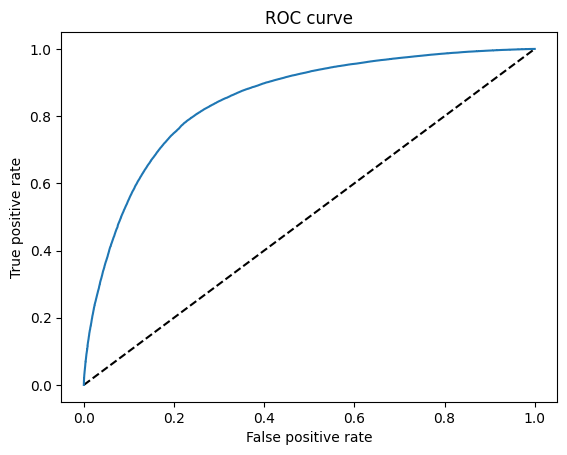

In [94]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.savefig('data/output/naive_bayes/ROC.png')
plt.show()